# CMS Readmission Rates

**DATA602 Final Project**

**Student:** Hala Algrain

## Introduction

The Hospital Readmissions Reduction Program (HRRP) is a Centers for Medicare and Medicaid Services (CMS) value-based purchasing program that aims to reduce readmission rates in 6 target conditions. [1]

1. Acute mycardial infarction (ami)
2. Pneumonia (pn)
3. Heart failure (hf)
4. Chronic obstructive pulmondary disease (copd)
5. Coronary artery bypass graft(cabg)
6. Total knee and hip arthroplastry (hka)

Most hospitals who treat a certain number of patients with these conditions must report their 30-day readmission rates to CMS. The worst performing hospitals are penalized via reduced payments. 

The HRRP program beganin 2012 with ami, pn, and hf. In 2015, copd was added. In 2017, cabg and hka were added to the program.

The HRRP uses the Excess Readmission Ratio (ERR) to assess a hospital's performance. ERRs below 1 show a less than average readmission rate while ERRs above 1 demonstrate a greater than average readmission rate. The higher the ERR the worse the hospital is doing.

## Problem Statement

Reporting quality measures is very costly with an annual cost of over $15 billion [2]. While the HRRP has successfully reduced readmissions, these reductions are variable acroos hospital and patient population groups; hospitals serving the most vulnerable patients often are penalized the most and have the least amount of improvement. [3] There is also evidence that the HRRP program is associated with increased mortality for heart failure and pneumonia [4]. 

Pneumonia in particular is a broad diagnostic label that can encompass a variety of acute and chronic causes e.g. bacterial infection versus post covid-19 pneumonia. Further bringing into question the utlity of how well hospitals can influence change in response to their performance metrics.

## Data Description

The dataset sources:
1. ERRs from CMS' HRRP Program [1]
2. Demographic information from Census Bureau’s Geocoder API [5]
3. Medicaid expansion status from Kaiser Family Foundation [6]

Data dictionary for final model:

- `'hospital_ccn'` unique hospital identifier
- `'cms_region_code'` 1 out of 10 regional US areas *Evidence they have outcome differences.*
- `'ownership_nonprofit'` binary variable if the hospital operates as a non-profit
- `'ownership_government'` binary variable if the hospital is operated by the government
- `'ownership_forprofit'` binary variable if the hospital operates as a for-profit
- `'teaching_hospital'` binary variable for hospitals academic teaching status
- `'expanded_2014'` whether a hospital expanded their Medicaid eligibility in 2014 under the ACA
- `'ruca'` Rural-Urban Commuting Area designation code of the corresponding census tract
- `'beds'` number of beds
- `'cah'` critical access hospital
- `'per_cap_inc'` per capita income of the corresponding census tract
- `'unemployment'` percentage of unemployed in the corresponding census tract
- `'black'` percentage of black people in the corresponding census tract
- `'asian'` percentage of asian people in the corresponding census tract
- `'hispanic'` percentage of hispanic people in the corresponding census tract
- `'err_for_ami'` excess readmission ratio for ami
- `'err_for_hf'` excess readmission ratio for hf
- `'err_for_hka'` excess readmission ratio for hka
- `'err_for_copd'` excess readmission ratio for copd
- `'err_for_cabg'` excess readmission ratio for cabg
- `'binary_pn'` binarized variable of `err_for_pneumonia`

## Analysis Goal

The target outcome is ERR for pneumonia `err_for_pneumonia` . The goal is to see how well pneumonia can be predicted using the other ERR measures. This would inform policy change on the usefulness of this particular readmission rate and possibly reduce costs and/or help hone better measures.

### Preliminary Data Cleaning

In [1]:
#importing packages
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#importing dataset
CMS_data= pd.read_csv('CMS_data.csv')
CMS_data.shape

(3688, 158)

In [2]:
# turn wide to long
# keep underscore at the end to work
CMS_long = pd.wide_to_long(CMS_data, stubnames=['err_for_pneumonia_','err_for_ami_','err_for_hf_',
                                          'err_for_hka_','err_for_copd_','err_for_cabg_',
                                          'white_','black_','asian_','hispanic_',
                                          'per_cap_inc_','unemployment_','bachelor_or_higher_'],
                           i='hospital_ccn', j='year')

#remove multi-index
CMS_long = CMS_long.reset_index()

In [3]:
# drop columns not in alignment with analysis goal
CMS_drop = CMS_long.drop(columns=['hosp_name_hcr','hospital_name','prvdr_ctrl_type_cd','state',      #duplicates
                      'ipf','oltc','irf','nf','icf','snf',                                     #admin data and segmentation
                      'initial_rpch_or_cah','ipf_provider_number','ipf_provider_number.1',   #col all NaNs
                      'snf_provider_number','swing_bed_snf_provider_number','nf_provider_number',
                      'irf_provider_number','irf_provider_number.1','swing_bed_nf_provider_number',
                      'icf_provider_number','subprovider_1','hospital_type','subprovider_1_provider_number',
                      'subprovider_2_provider_number', 'subprovider_iii_indicator','subprovider_2',
                      'labor_and_delivery','intensive_care_unit','cardiac_catheterization','initial_rph_or_cah',
                      'cardiac_catheterization.1','surgical_intensive_care_unit','nursery',
                      'coronary_care_unit','other_special_care','hospice','hospital_adults_&_pediatrics',
                      'burn_intensive_care_unit','cardiac_catheterization.2','critical_access_hosp_hcr',
                      'total_hospital','total_facility','rpch_or_cah','initial_rpch_or_cah','rph_or_cah',
                      'prvdr_ctgry_sbtyp_cd_formatted','hospital_type', 'total',          
                      'ruca_description', 'street','city','hospital_county','zip','tract' # granular not useful 
                     ])


####  2019 is the best year for this analysis. Reporting for all conditions was underway by 2019 yet it's data that isn't confounded by the COVID-19 pandemic.

In [4]:
# extracting 2019 data
df= CMS_drop[CMS_drop.year == 2019]

#removing underscore from ends of columns
df.columns = df.columns.str.rstrip('_')

# final dataframe to be used in EDA
df.head()

,hospital_ccn,year,state_abbreviation,cms_region_code,ruca,ownership_forprofit,ownership_government,cah,beds,expanded_2014,ownership_nonprofit,teaching_hospital,err_for_pneumonia,err_for_ami,err_for_hf,err_for_hka,err_for_copd,err_for_cabg,white,black,asian,hispanic,per_cap_inc,unemployment,bachelor_or_higher
6,10001,2019,AL,4.0,1.0,0.0,1.0,0,332,False,0.0,1.0,1.0454,1.0072,1.0135,1.0468,0.9913,1.1392,0.875272,0.996801,0.080778,0.048367,25565.0,0.123702,0.392215
15,10005,2019,AL,4.0,4.0,0.0,1.0,0,195,False,0.0,0.0,0.9677,0.9518,1.0288,1.0913,0.9054,NaN,2.123546,0.774713,0.007986,0.139299,24362.0,0.142012,0.418612
24,10006,2019,AL,4.0,1.0,1.0,0.0,0,223,False,0.0,0.0,0.9817,1.0332,0.9558,1.3032,0.9974,1.1655,2.870153,0.963170,0.007950,0.421759,19702.5,0.328939,0.303064
33,10007,2019,AL,4.0,7.0,0.0,1.0,0,45,False,0.0,0.0,0.9891,0.9768,1.1313,1.1117,1.0096,NaN,1.469827,0.465761,0.003241,0.035635,23710.5,0.245147,0.224750
42,10008,2019,AL,4.0,3.0,0.0,1.0,0,29,False,0.0,0.0,0.9805,1.0067,1.0064,NaN,0.9730,NaN,0.683967,0.212487,0.044964,0.005653,23630.0,0.024217,0.140545


## Exploratory Data Analysis

#### Checking for Missing Values and Data Types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3688 entries, 6 to 33189
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hospital_ccn          3688 non-null   int64  
 1   year                  3688 non-null   int64  
 2   state_abbreviation    3379 non-null   object 
 3   cms_region_code       3043 non-null   float64
 4   ruca                  3201 non-null   float64
 5   ownership_forprofit   3239 non-null   float64
 6   ownership_government  3239 non-null   float64
 7   cah                   3688 non-null   int64  
 8   beds                  3239 non-null   object 
 9   expanded_2014         3370 non-null   object 
 10  ownership_nonprofit   3239 non-null   float64
 11  teaching_hospital     3231 non-null   float64
 12  err_for_pneumonia     3053 non-null   float64
 13  err_for_ami           2918 non-null   float64
 14  err_for_hf            3024 non-null   float64
 15  err_for_hka         

Missing data is primarily due to lack of data availability:
- Since demographic data comes the same source, they have the same number of nulls.
- There is a threshold for a minimum number of cases before a hospital must report `ERR` for a particular condition. Thus,the variability in available data, e.g. hospitals simply don't perform `cabg` procedures. This could still be useful to the analysis.

Data types are mostly correct but requires further understanding (below):
- `per_cap_inc` and `beds` are numerical.
- `asian`, `white`, `black`, `hispanic`, `unemployment`, `bachelor_or_higher` are percentages.
- The following are Boolean variables but have missing values so won't be converted: `ownership_forprofit`, `ownership_nonprofit`, `ownership_government`, `cah` also from the same data source.

In [6]:
df.describe()

,hospital_ccn,year,cms_region_code,ruca,ownership_forprofit,ownership_government,cah,ownership_nonprofit,teaching_hospital,err_for_pneumonia,err_for_ami,err_for_hf,err_for_hka,err_for_copd,err_for_cabg,white,black,asian,hispanic,per_cap_inc,unemployment,bachelor_or_higher
count,3688.000000,3688.0,3043.000000,3201.000000,3239.000000,3239.000000,3688.000000,3239.000000,3231.000000,3053.000000,2918.000000,3024.000000,2812.000000,3034.000000,1148.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000
mean,267971.420011,2019.0,5.186001,2.565979,0.247299,0.145724,0.009761,0.606977,0.383782,1.001974,1.000969,1.001527,1.006511,1.001251,1.004557,2.796476,0.593251,0.088114,0.644161,31808.505095,0.243845,0.593039
std,164552.754833,0.0,2.321378,6.281256,0.431508,0.352884,0.098330,0.488497,0.486381,0.078273,0.054292,0.072842,0.121803,0.059273,0.102286,6.830284,1.790874,0.142471,2.628667,14648.995630,0.546891,0.976198
min,10001.000000,2019.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.761000,0.747900,0.746700,0.598200,0.812600,0.730500,0.004924,0.000000,0.000000,0.000000,970.000000,0.000000,0.002839
25%,110191.750000,2019.0,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.951000,0.975425,0.956975,0.935400,0.965000,0.939175,0.750600,0.032479,0.011836,0.052924,22961.500000,0.043446,0.181792
50%,260080.500000,2019.0,5.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.996600,0.997700,0.998100,0.996500,0.997500,0.999200,0.939993,0.133913,0.038038,0.153003,28247.192308,0.086514,0.333821
75%,390313.250000,2019.0,6.000000,4.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.048400,1.027175,1.043900,1.067900,1.033250,1.064550,2.559554,0.507996,0.103489,0.438180,36038.900000,0.230398,0.621427
max,670899.000000,2019.0,10.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.380100,1.292700,1.339400,1.825600,1.322200,1.707200,96.790789,25.012423,1.594522,33.839833,151643.000000,5.122792,13.236934


In [7]:
# after further exploration
# grouping variables by type for later reference.

int_cols = ['beds']

bool_cols = ['teaching_hospital', 'expanded_2014', 'cah',
           'ownership_forprofit', 'ownership_nonprofit', 'ownership_government']

ordinal_cols = ['ruca', 'cms_region_code']

float_cols = ['err_for_hf','err_for_hka','err_for_copd',
              'err_for_cabg','err_for_pneumonia','err_for_ami',
             'white','black','asian','hispanic',
             'per_cap_inc','unemployment','bachelor_or_higher']

- `ruca` 1 - 4 and `cms_region_code` 1-10 are both still categorical and stays as floats to accomodate null values.
- `beds` must be converted to a numerical column

In [8]:
# converting beds to numerical
df['beds'] = pd.to_numeric(df['beds'], errors='coerce') #change error to NaN

In [9]:
# checking conversion
df.beds.describe()

count    3232.00000
mean      198.49474
std       208.05316
min         1.00000
25%        54.00000
50%       135.00000
75%       268.00000
max      2812.00000
Name: beds, dtype: float64

#### `expanded_2014` shouldn't have any missing since it's known information

In [10]:
# rows without expansion information
df['expanded_2014'].isna().sum()

318

In [11]:
# rows without state_abbreviation
df['state_abbreviation'].isna().sum()

309

Expanded states might be related to nulls in state abbreviations. Without knowing the state, we cannot know whether the state expanded or not.

In [12]:
# checking for observations where both columns are null
df.query('expanded_2014.isnull() & state_abbreviation.isnull()', engine='python').head(10)

,hospital_ccn,year,state_abbreviation,cms_region_code,ruca,ownership_forprofit,ownership_government,cah,beds,expanded_2014,ownership_nonprofit,teaching_hospital,err_for_pneumonia,err_for_ami,err_for_hf,err_for_hka,err_for_copd,err_for_cabg,white,black,asian,hispanic,per_cap_inc,unemployment,bachelor_or_higher
51,10009,2019,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,10015,2019,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,10027,2019,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,10043,2019,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,10050,2019,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,10066,2019,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726,10137,2019,NaN,NaN,2.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
771,10146,2019,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0473,0.9837,0.972,NaN,0.9944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
807,10152,2019,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
861,10170,2019,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This coincides with observations with mostly missing information. There is some readmission rates that could still be useful so we'll drop columns that don't have any readmission rates.

In [13]:
# checking for observations where all ERR are null
df.query('err_for_pneumonia.isnull() & err_for_ami.isnull() & err_for_hf.isnull() & err_for_hka.isnull() & err_for_copd.isnull() & err_for_cabg.isnull()',
         engine='python')

,hospital_ccn,year,state_abbreviation,cms_region_code,ruca,ownership_forprofit,ownership_government,cah,beds,expanded_2014,ownership_nonprofit,teaching_hospital,err_for_pneumonia,err_for_ami,err_for_hf,err_for_hka,err_for_copd,err_for_cabg,white,black,asian,hispanic,per_cap_inc,unemployment,bachelor_or_higher
51,10009,2019,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,10010,2019,AL,NaN,1.0,NaN,NaN,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.788864,0.146487,0.059417,0.014948,36563.00,0.030441,0.224589
87,10015,2019,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,10018,2019,AL,4.0,1.0,0.0,1.0,0,6.0,False,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.445045,0.413560,0.072049,0.033031,8614.00,0.154301,0.110875
159,10025,2019,AL,NaN,1.0,NaN,NaN,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.675624,0.321214,0.000000,0.053114,25391.00,0.051517,0.089472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33153,670121,2019,TX,NaN,NaN,1.0,0.0,0,23.0,False,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.837253,0.047507,0.030574,0.129821,38956.00,0.024590,0.332314
33162,670122,2019,TX,NaN,1.1,0.0,0.0,0,186.0,False,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.777247,0.071087,0.058454,0.284087,35946.00,0.048676,0.254107
33171,670124,2019,TX,NaN,NaN,1.0,0.0,0,16.0,False,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.715353,0.602957,0.162679,1.426343,16752.75,0.250149,0.239761
33180,670128,2019,NaN,NaN,NaN,0.0,0.0,0,25.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We'd lose other variables that could add to the analysis so will not drop even if not ERRs are presents since our outcome variable will already be narrowing down our observations. But we can drop columns that have only the `hospital_ccn` , `year`, `ccn` columns

In [14]:
df.shape

(3688, 25)

In [15]:
# 25 columns. 3 columns have no missing.
df = df.dropna(thresh=4)

df.shape

(3488, 25)

#### Independent variable missing values will be addressed during the pre-processing stage (as per instructions).

### Exploratory Visual Analysis

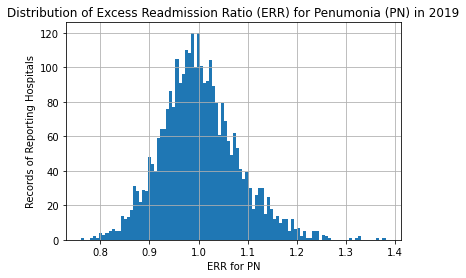

In [16]:
df.err_for_pneumonia.hist(bins=100)
plt.title('Distribution of Excess Readmission Ratio (ERR) for Penumonia (PN) in 2019')
plt.xlabel('ERR for PN')
plt.ylabel('Records of Reporting Hospitals')
plt.show()

Relatively balanced distribution. Expected middle peak since these are rates are ratios calculated in relation to other hospital's performance. Slightly skewed to the left with a few outliers on the right showing the worst performers.

#### We can contrast that with the ERR for Hip and Knee Arthroplasty

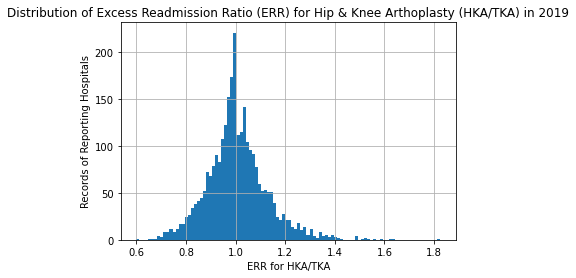

In [17]:
df.err_for_hka.hist(bins=100)
plt.title('Distribution of Excess Readmission Ratio (ERR) for Hip & Knee Arthoplasty (HKA/TKA) in 2019')
plt.xlabel('ERR for HKA/TKA')
plt.ylabel('Records of Reporting Hospitals')
plt.show()

Similar overall distribution but with a more narrow peak due to the smaller sample size.

In [18]:
miss_pn = df['err_for_pneumonia'].isna().sum()
miss_hka = df['err_for_hka'].isna().sum()
print(f'Missing observations for pneumonia: {miss_pn}')
print(f'Missing observations for total knee and hip arthoplasty: {miss_hka}')

Missing observations for pneumonia: 435
Missing observations for total knee and hip arthoplasty: 676


In [19]:
df.err_for_pneumonia.describe()

count    3053.000000
mean        1.001974
std         0.078273
min         0.761000
25%         0.951000
50%         0.996600
75%         1.048400
max         1.380100
Name: err_for_pneumonia, dtype: float64

The mean is around 1 which confirms that the way CMS calculates ERR is in alignment with its policy for penalizing hospitals. ERRs below 1 show a below than average readmission rate while ERRs above 1 demonstrate an above average readmission rate. The higher the ERR the worse the hospital is doing.

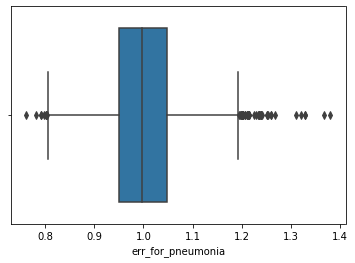

In [20]:
# identifying outliers

sns.boxplot(x=df['err_for_pneumonia']);

It's important that ERR calculations aim to identify outliers to both penalize and rewards. Our modeling should do its best to account for outliers instead of removing them totally.

### Our analysis goal is to see whether the ERR of pneumonia is predictable based on other parameters. A meaningful classification would be on the basis of the CMS cutoff of 1 as a measure of performance. 

#### binarizing target variable

In [21]:
# creating a column for the binary outcome 
df['binary_pn'] = df['err_for_pneumonia']

# if the ERR is above 1 plus one standard dev then our target outcome is 1
df.loc[df['err_for_pneumonia'] > 1.08, 'binary_pn'] = 1

# otherwise zero. Doing this to account for missing
df.loc[df['err_for_pneumonia'] <= 1.08, 'binary_pn'] = 0

In [22]:
# creating a column for the binary outcome 
df['binary_pn'] = df['err_for_pneumonia']

# if the ERR is above 1 then our target outcome is 1
df.loc[df['err_for_pneumonia'] > 1, 'binary_pn'] = 1

# otherwise zero. Doing this to account for missing
df.loc[df['err_for_pneumonia'] <= 1, 'binary_pn'] = 0

In [23]:
# checking conversion of column
# same number of missing
df['binary_pn'].isna().sum()

435

In [24]:
# same number of missing
df['err_for_pneumonia'].isna().sum()

435

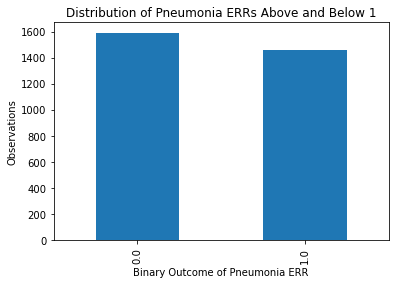

In [25]:
df['binary_pn'].value_counts().plot.bar()
plt.title('Distribution of Pneumonia ERRs Above and Below 1')
plt.xlabel('Binary Outcome of Pneumonia ERR')
plt.ylabel('Observations')
plt.show()

Slightly imbalanced distribution. Not significant enough to cause any issues when modeling. The goal of the analysis means we want to better identify those with a higher ERR than 1 which we'll keep in mind during model evaluation.

In [26]:
df['binary_pn'].value_counts()

0.0    1591
1.0    1462
Name: binary_pn, dtype: int64

#### Missing value for target variable shouldn't be imputed so dropping if outcome is missing.

In [27]:
df = df.dropna(subset=['binary_pn'])
df.shape

(3053, 26)

#### checking for multicollinearity

In [28]:
#for further EDA
num_var_x = ['beds','unemployment','bachelor_or_higher', 'per_cap_inc',
               'white','black','asian','hispanic',
               'err_for_pneumonia','err_for_ami','err_for_hf',
               'err_for_hka','err_for_copd','err_for_cabg']


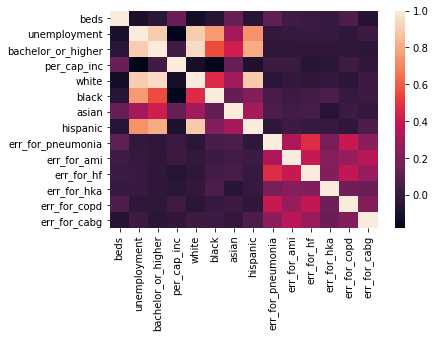

In [29]:
sns.heatmap(df[num_var_x].corr())
plt.show()

Some high correlation on the left upper hand side so must look more closely at the highest correlations

In [30]:
corrs = df[num_var_x].corr().unstack()
corrs = pd.DataFrame(corrs)
corrs = corrs.reset_index()
corrs.columns = ['col1', 'col2', 'correlation']

corrs.query('col1 != col2 & correlation >= 0.75').sort_values(by='correlation', ascending=False)

,col1,col2,correlation
32,bachelor_or_higher,white,0.947420
58,white,bachelor_or_higher,0.947420
18,unemployment,white,0.903966
57,white,unemployment,0.903966
16,unemployment,bachelor_or_higher,0.902754
29,bachelor_or_higher,unemployment,0.902754
63,white,hispanic,0.896028
102,hispanic,white,0.896028
35,bachelor_or_higher,hispanic,0.810861
100,hispanic,bachelor_or_higher,0.810861


Race and socioeconomic characteristics such as education and employment are usually connected. This is an unsually high correlation and might confound the model. 

- `unemployment` and `bachelor_or_higher` (i.e. educational level) are social determinants of health. Factoring in access to healthcare is important to readmission so we'll keep `unemployment`. 
- `hispanic` which as a minority is in alignment with the `asian` and `black` features. Thus, we can exclude the variable `white` if race is already accounted for in the model as evidenced by it's high collinearity with other variables. 

#### Variables for Modeling

In [31]:
df = df.drop(columns=['white','year','state_abbreviation',
                      'bachelor_or_higher','err_for_pneumonia',
                      'hospital_ccn'
                     ])

In [32]:
df['expanded_2014'] = df['expanded_2014'].astype('object')

df['cah'] = df['cah'].astype('object')
df['teaching_hospital'] = df['teaching_hospital'].astype('object')

df['ownership_forprofit'] = df['ownership_forprofit'].astype('object')
df['ownership_government'] = df['ownership_government'].astype('object')
df['ownership_nonprofit'] = df['ownership_nonprofit'].astype('object')

df['cms_region_code'] = df['cms_region_code'].astype('object')
df['ruca'] = df['ruca'].astype('object')


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3053 entries, 6 to 33144
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cms_region_code       2830 non-null   object 
 1   ruca                  2941 non-null   object 
 2   ownership_forprofit   2963 non-null   object 
 3   ownership_government  2963 non-null   object 
 4   cah                   3053 non-null   object 
 5   beds                  2960 non-null   float64
 6   expanded_2014         3035 non-null   object 
 7   ownership_nonprofit   2963 non-null   object 
 8   teaching_hospital     2957 non-null   object 
 9   err_for_ami           2918 non-null   float64
 10  err_for_hf            3021 non-null   float64
 11  err_for_hka           2695 non-null   float64
 12  err_for_copd          3027 non-null   float64
 13  err_for_cabg          1148 non-null   float64
 14  black                 2892 non-null   float64
 15  asian               

In [34]:
df = df.reset_index(drop=True)
df.head()

,cms_region_code,ruca,ownership_forprofit,ownership_government,cah,beds,expanded_2014,ownership_nonprofit,teaching_hospital,err_for_ami,err_for_hf,err_for_hka,err_for_copd,err_for_cabg,black,asian,hispanic,per_cap_inc,unemployment,binary_pn
0,4.0,1.0,0.0,1.0,0,332.0,False,0.0,1.0,1.0072,1.0135,1.0468,0.9913,1.1392,0.996801,0.080778,0.048367,25565.0,0.123702,1.0
1,4.0,4.0,0.0,1.0,0,195.0,False,0.0,0.0,0.9518,1.0288,1.0913,0.9054,NaN,0.774713,0.007986,0.139299,24362.0,0.142012,0.0
2,4.0,1.0,1.0,0.0,0,223.0,False,0.0,0.0,1.0332,0.9558,1.3032,0.9974,1.1655,0.963170,0.007950,0.421759,19702.5,0.328939,0.0
3,4.0,7.0,0.0,1.0,0,45.0,False,0.0,0.0,0.9768,1.1313,1.1117,1.0096,NaN,0.465761,0.003241,0.035635,23710.5,0.245147,0.0
4,4.0,3.0,0.0,1.0,0,29.0,False,0.0,0.0,1.0067,1.0064,NaN,0.9730,NaN,0.212487,0.044964,0.005653,23630.0,0.024217,0.0


### Data Processing

#### Splitting data

In [35]:
# creating numerical variables
num_var = ['err_for_hf','err_for_hka','err_for_copd','err_for_cabg','err_for_ami',
             'black','asian','hispanic',
             'per_cap_inc','unemployment']

In [36]:
# creating categorical variables
cat_var = ['expanded_2014','cah','teaching_hospital',
           'ownership_forprofit','ownership_government','ownership_nonprofit',
           'ruca', 'cms_region_code']

In [37]:
from sklearn.model_selection import train_test_split

X = df[[x for x in df.columns if x != 'binary_pn']]
y = df['binary_pn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1989)

print(f'Training examples: {X_train.shape[0]}')
print(f'Test examples: {X_test.shape[0]}')
print('\nFeature names:')
print(*X.columns, sep='\n')

Training examples: 2442
Test examples: 611

Feature names:
cms_region_code
ruca
ownership_forprofit
ownership_government
cah
beds
expanded_2014
ownership_nonprofit
teaching_hospital
err_for_ami
err_for_hf
err_for_hka
err_for_copd
err_for_cabg
black
asian
hispanic
per_cap_inc
unemployment


#### Feature Processing

In [38]:
# importing modeling packages
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [39]:
num_pipe = Pipeline([('impute', SimpleImputer(strategy='median')), ('scale', StandardScaler())])


In [40]:
# checking numerical pipeline
num_pipe.fit_transform(X_train[num_var]).shape

(2442, 10)

In [41]:
num_pipe.fit_transform(X_train[num_var])[0,:]

array([-0.10641853, -0.09034656, -0.00216918, -0.03443125, -0.06556888,
       -0.22461388, -0.15389977, -0.21101564, -0.06302125, -0.38872255])

Even though most are already in floats we want to make sure, categorical variables are imputed properly

In [42]:
cat_pipe = Pipeline([('impute_cat', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [43]:
cat_pipe = Pipeline([('impute_cat', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [44]:
# checking categorical pipeline

cat_pipe.fit_transform(X_train[cat_var])[0, :].todense()

matrix([[1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0.]])

In [45]:
cat_pipe.fit_transform(X_train[cat_var])

<2442x40 sparse matrix of type '<class 'numpy.float64'>'
	with 19536 stored elements in Compressed Sparse Row format>

####  Pre-processing Pipeline

In [46]:
proc_pipe = ColumnTransformer(transformers=[('proc_numeric', num_pipe, num_var),
                                                      ('create_dummies', cat_pipe, cat_var)])

proc_pipe

ColumnTransformer(transformers=[('proc_numeric',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['err_for_hf', 'err_for_hka', 'err_for_copd',
                                  'err_for_cabg', 'err_for_ami', 'black',
                                  'asian', 'hispanic', 'per_cap_inc',
                                  'unemployment']),
                                ('create_dummies',
                                 Pipeline(steps=[('impute_cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['expanded_2014', 'cah', 'teaching_hospital',
               

## Modeling

The following models are trialed and tuned using GridSearchCV.
- Logistic Regression simple, with PCA, and with k-Means
- Decision Trees
- Random Forests
- Support Vector Machines 
- K-Nearest Neighbor

### Logistic Regression

In [47]:
from sklearn.model_selection import GridSearchCV
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [48]:
# lg: logistic regression
lg_pipe = Pipeline([('fp', proc_pipe),
                    ('lg', LogisticRegression(solver='liblinear', max_iter=200))
                    ])

start = time.time()

# setting LG param grid
params = {
    'lg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'lg__class_weight': [None, 'balanced'],
    #'lg__penalty':['l2','none']
}

model_lg = GridSearchCV(lg_pipe, param_grid = params, scoring='accuracy', cv=5)
model_lg = model_lg.fit(X_train, y_train)


end = time.time()
print(end - start, "seconds")

model_lg.best_estimator_

1.9029321670532227 seconds


Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [49]:
model_lg.best_score_

0.6813947835998525

> Best validation accuracy is ~ 68%. 

We can search around the best parameters to try to improve upon the model.

In [50]:
# searching lg param grid
params = {
    'lg__C': [0.001, 0.005, 0.015, 0.0001],
    'lg__class_weight': [None, 'balanced'],
}

model_lg = GridSearchCV(lg_pipe, param_grid = params, scoring='accuracy', cv=5)
model_lg = model_lg.fit(X_train, y_train)

model_lg.best_estimator_

Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [51]:
model_lg.best_score_

0.6813956217104161

> This did not improve validation accuracy despite increasing the regularization strength. Thus, the highest accuracy for a logistic regression model remains at 68%.

### Logistic Regression Model Results

In [52]:
print(f'Logistic Regression Validation score: {model_lg.best_score_:.2%}')
print(f'Logistic Regression Full training score: {model_lg.score(X_train, y_train):.2%}')
print(f'Logistic Regression Test score: {model_lg.score(X_test, y_test):.2%}')

Logistic Regression Validation score: 68.14%
Logistic Regression Full training score: 68.80%
Logistic Regression Test score: 67.59%


In [53]:
print(classification_report(y_test, model_lg.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.67      0.77      0.71       323
         1.0       0.69      0.57      0.62       288

    accuracy                           0.68       611
   macro avg       0.68      0.67      0.67       611
weighted avg       0.68      0.68      0.67       611



> There is no evidence of overfitting when comparing training and test scores. 67% of the true positives were correctly classified (recall). Accuracy is still a good measure for this classification problem since it is relatively balanced. This percentage of correct predictions is 68% (accuracy).

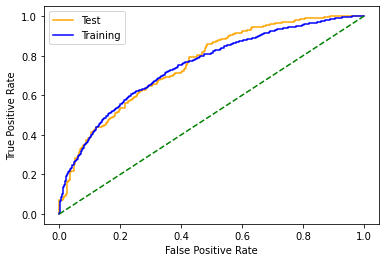

In [54]:
from sklearn.metrics import roc_curve

fpr_test, tpr_test, thr_test = roc_curve(y_test, model_lg.predict_proba(X_test)[:,1])
fpr_tr, tpr_tr, thr_tr = roc_curve(y_train, model_lg.predict_proba(X_train)[:,1])

plt.plot(fpr_test, tpr_test, 'orange')
plt.plot(fpr_tr, tpr_tr, 'blue')
plt.plot(fpr_tr, fpr_tr, color='green', linestyle='dashed')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.show()

> ROC curve is well-suited for a balanced outcome. As the threshold increases and the number of false positives increase, the number of true positives continues to increase as well. The curve shows the is model not the best at discriminating but is still better than random guessing.

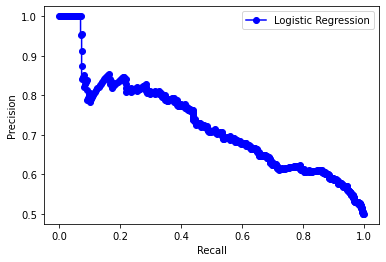

In [55]:
from sklearn.metrics import precision_recall_curve

def generate_pr(y, probs):
    pr, rec, _ = precision_recall_curve(y, probs)
    return pr, rec

y_testpr_lg = model_lg.predict_proba(X_test)
pr_lr, rec_lr = generate_pr(y_test, y_testpr_lg[:,1])

plt.plot(rec_lr, pr_lr,'-ob')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(['Logistic Regression'])
plt.show()

> Though no class imbalances. The optimal threshold point for maximal precision and recall trade-off may be slighly lower than the default of 0.5

### Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
# dt: decision tree
dt_pipe = Pipeline([('fp', proc_pipe),
                    ('dt', DecisionTreeClassifier())
                    ])

start = time.time()

# setting dt param grid
params = {
    'dt__max_depth': [4, 6, 8, 10, 12],
    'dt__min_samples_split': [0.01, 0.02, 0.04, 0.06, 0.08],
    'dt__class_weight': [None, 'balanced'],
}

model_dt = GridSearchCV(dt_pipe, param_grid = params, scoring='accuracy', cv=5)
model_dt = model_dt.fit(X_train, y_train)


end = time.time()
print(end - start, "seconds")

model_dt.best_estimator_

7.64497709274292 seconds


Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [58]:
model_dt.best_score_

0.667473767139361

> The model took slighly longer than logistic regression but has a lower validation score of  67%. Perhaps this could improve with more tuning.

In [59]:
# searching dt param grid

params = {
    'dt__max_depth': [2,3,4,5],
    'dt__min_samples_split': [0.08, 0.1, 0.5],
    'dt__class_weight': [None, 'balanced'],
}

model_dt = GridSearchCV(dt_pipe, param_grid = params, scoring='accuracy', cv=5)
model_dt = model_dt.fit(X_train, y_train)

model_dt.best_estimator_

Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [60]:
model_dt.best_score_

0.672799959770693

> This slightly improved validation score accuracy by 0.1%

In [61]:
# searching dt param grid

params = {
    'dt__max_depth': [4,5,6,7],
    'dt__min_samples_split': [ 0.1, 0.2, 0.3, 0.4],
    'dt__class_weight': [None, 'balanced'],
}

model_dt = GridSearchCV(dt_pipe, param_grid = params, scoring='accuracy', cv=5)
model_dt = model_dt.fit(X_train, y_train)

model_dt.best_estimator_

Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [62]:
model_dt.best_score_

0.6760778101847196

> Negligible improvement so not worth continuing to search.

### Decision Tree Model Results

In [63]:
print(f'Decision Tree Validation score: {model_dt.best_score_:.2%}')
print(f'Decision Tree Full training score: {model_dt.score(X_train, y_train):.2%}')
print(f'Decision Tree Test score: {model_dt.score(X_test, y_test):.2%}')

Decision Tree Validation score: 67.61%
Decision Tree Full training score: 68.71%
Decision Tree Test score: 65.96%


In [64]:
print(classification_report(y_test, model_dt.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.66      0.74      0.70       323
         1.0       0.66      0.57      0.61       288

    accuracy                           0.66       611
   macro avg       0.66      0.65      0.65       611
weighted avg       0.66      0.66      0.66       611



> Very similar to logistic regression but accuracy, precision, and recall all lost 1-2% percentage points.

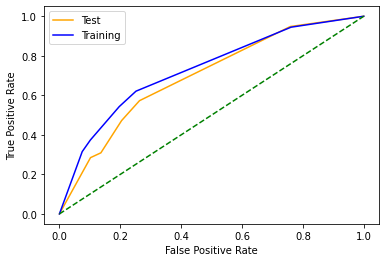

In [65]:
fpr_test, tpr_test, thr_test = roc_curve(y_test, model_dt.predict_proba(X_test)[:,1])
fpr_tr, tpr_tr, thr_tr = roc_curve(y_train, model_dt.predict_proba(X_train)[:,1])

plt.plot(fpr_test, tpr_test, 'orange')
plt.plot(fpr_tr, tpr_tr, 'blue')
plt.plot(fpr_tr, fpr_tr, color='green', linestyle='dashed')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.show()

> Decision tree is also more overfit than logisitc regression. Not great but still better than a blind guess.

### Random Forest Classification

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
# rf: random forest
rf_pipe = Pipeline([('fp', proc_pipe),
                    ('rf', RandomForestClassifier())
                    ])

start = time.time()

# setting rf param grid
params = {
    'rf__n_estimators': [100, 200]
}

model_rf = GridSearchCV(rf_pipe, param_grid = params, scoring='accuracy', cv=5, refit=True)
model_rf = model_rf.fit(X_train, y_train)


end = time.time()
print(end - start, "seconds")

model_rf.best_estimator_

4.923433065414429 seconds


Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [68]:
model_rf.best_score_

0.6654287773643099

> Interesting how the more complex models are doing worse. Even lower validation score than both logistic regression (68%) and decision trees (66%)

In [69]:
# searching rf param grid
params = {
    'rf__n_estimators': [200,250,300,500]
}

model_rf = GridSearchCV(rf_pipe, param_grid = params, scoring='accuracy', cv=5, refit=True)
model_rf = model_rf.fit(X_train, y_train)

model_rf.best_estimator_

Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [70]:
model_rf.best_score_

0.6674838244661235

> Though slightly faster (5 seconds) than a decision tree (8 seconds), the performance is worse.

In [71]:
# searching rf param grid
params = {
    'rf__n_estimators': [300,325,350,400,450]
}

model_rf = GridSearchCV(rf_pipe, param_grid = params, scoring='accuracy', cv=5, refit=True)
model_rf = model_rf.fit(X_train, y_train)

model_rf.best_estimator_

Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [72]:
model_rf.best_score_

0.6625649535686747

### Random Forest Model Results

In [73]:
print(f'Logistic Regression Validation score: {model_rf.best_score_:.2%}')
print(f' Full training score: {model_rf.score(X_train, y_train):.2%}')
print(f' Test score: {model_rf.score(X_test, y_test):.2%}')

Logistic Regression Validation score: 66.26%
 Full training score: 100.00%
 Test score: 65.63%


In [74]:
print(classification_report(y_test, model_rf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.66      0.72      0.69       323
         1.0       0.65      0.59      0.62       288

    accuracy                           0.66       611
   macro avg       0.66      0.65      0.65       611
weighted avg       0.66      0.66      0.65       611



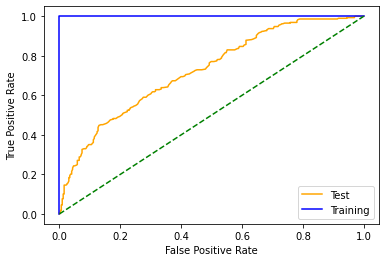

In [75]:
fpr_test, tpr_test, thr_test = roc_curve(y_test, model_rf.predict_proba(X_test)[:,1])
fpr_tr, tpr_tr, thr_tr = roc_curve(y_train, model_rf.predict_proba(X_train)[:,1])

plt.plot(fpr_test, tpr_test, 'orange')
plt.plot(fpr_tr, tpr_tr, 'blue')
plt.plot(fpr_tr, fpr_tr, color='green', linestyle='dashed')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.show()

> Once hypertuned better than random forest outperforms the decision tree by about a percentage point. However, this comes at the cost of some severe overfitting.

### Support Vector Machine

In [76]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [77]:
# svm: support vector machine
svm_pipe = Pipeline([('fp', proc_pipe),
                    ('svm', SVC())])

start = time.time()

# setting LG param grid
params = {
    'svm__C': [0.01, 0.1, 1, 10, 100, 1000],
    'svm__kernel': ['linear','rbf']
}

model_svm = GridSearchCV(svm_pipe, param_grid = params, scoring='accuracy', cv=5)
model_svm = model_svm.fit(X_train, y_train)


end = time.time()
print(end - start, "seconds")

model_svm.best_estimator_

201.970458984375 seconds


Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [78]:
model_svm.best_score_

0.6756688122297094

> SVM is slightly promising and may be a contender performance wise but the validation score is still under 70% and this doesn't justify the awful run time 198 seconds versus 5 seconds for logistic regression.

In [79]:
print(f'Support Vector Machine Validation score: {model_svm.best_score_:.2%}')
print(f'Support Vector Machine Full training score: {model_svm.score(X_train, y_train):.2%}')
print(f'Support Vector Machine Test score: {model_svm.score(X_test, y_test):.2%}')

Support Vector Machine Validation score: 67.57%
Support Vector Machine Full training score: 68.10%
Support Vector Machine Test score: 67.27%


In [80]:
print(classification_report(y_test, model_svm.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.66      0.80      0.72       323
         1.0       0.70      0.53      0.60       288

    accuracy                           0.67       611
   macro avg       0.68      0.66      0.66       611
weighted avg       0.68      0.67      0.67       611



> It took too long. The precision is higher but the accuracy and recall is lower than logistic regression.

### K-Nearest Neighbor

In [81]:
from sklearn.neighbors import KNeighborsClassifier

In [82]:
# kn: KNN
kn_pipe = Pipeline([('fp', proc_pipe),
                    ('kn', KNeighborsClassifier())
                    ])

start = time.time()

# setting kn param grid
params = {
    'kn__n_neighbors': [1, 4, 8, 10, 15],
    'kn__weights': ['uniform','distance']
}

model_kn = GridSearchCV(kn_pipe, param_grid = params, scoring='accuracy', cv=5)
model_kn = model_kn.fit(X_train, y_train)


end = time.time()
print(end - start, "seconds")

model_kn.best_estimator_

2.0683209896087646 seconds


Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [83]:
model_kn.best_score_

0.6572521707063597

> not unreasonable. continuing to hypertune.

In [84]:
# searching kn param grid
params = {
    'kn__n_neighbors': [15,16,20,30,50],
    'kn__weights': ['uniform','distance']
}

model_kn = GridSearchCV(kn_pipe, param_grid = params, scoring='accuracy', cv=5)
model_kn = model_kn.fit(X_train, y_train)

model_kn.best_estimator_

Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [85]:
model_kn.best_score_

0.6695321666834289

> A much better improvement but it's still not close to logistic regression.

### Refining logistic regression classifical model further

In [86]:
from sklearn.metrics import roc_auc_score

logreg = roc_auc_score(y_test, model_lg.predict_proba(X_test)[:,1]) 
dtr = roc_auc_score(y_test, model_dt.predict_proba(X_test)[:,1])
rndf = roc_auc_score(y_test, model_rf.predict_proba(X_test)[:,1])
knn = roc_auc_score(y_test, model_kn.predict_proba(X_test)[:,1])

print(f'Logistic Regression AUC: {logreg:.2%}')
print(f'Decision Tree AUC: {dtr:.2%}')
print(f'Random Forest AUC: {rndf:.2%}')
print(f'K-Nearest Neighbor AUC: {knn:.2%}')

Logistic Regression AUC: 75.78%
Decision Tree AUC: 69.39%
Random Forest AUC: 72.52%
K-Nearest Neighbor AUC: 70.44%


> AUC provides a way to compare models. As expected logisitc regression has the highest AUC only second to Random Forests which was very badly overfit.

#### Logisitic regression does not overfit, runs the fastest, and hasthe best accuracy score. So it's worth refining it even more..

### Logistic Regression with Principal Component Analysis (PCA)

In [87]:
from sklearn.decomposition import PCA

In [88]:
s = StandardScaler()
X_train_proc = proc_pipe.fit_transform(X_train)

p = PCA()
X_train_pca = p.fit_transform(X_train_proc)

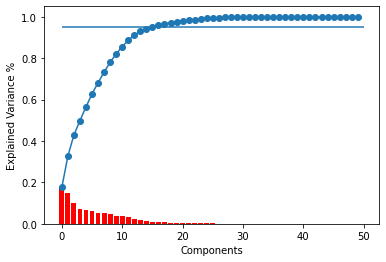

In [89]:
evr = p.explained_variance_ratio_

plt.plot(np.cumsum(evr), '-o')
plt.bar(np.arange(np.size(evr)), evr, color='red')
plt.ylabel('Explained Variance %')
plt.xlabel('Components')
plt.hlines(.95, 0, np.size(evr))
plt.show()

> Around the 15th component, most of the variance is explained. 

In [90]:
# lg_pca: logistic regression w/ pca
lg_pca_pipe = Pipeline([('fp', proc_pipe),
                        ('pca', PCA()),
                        ('lg', LogisticRegression(solver='liblinear', max_iter=200)),
                    
                    ])

start = time.time()

# setting lg_pca param grid
params = {
    'lg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'lg__class_weight': [None, 'balanced'],
    'pca__n_components': [2, 5, 10, 15, 20, 25, 30]
}

model_lg_pca = GridSearchCV(lg_pca_pipe, param_grid = params, scoring='accuracy', cv=5)
model_lg_pca = model_lg_pca.fit(X_train, y_train)


end = time.time()
print(end - start, "seconds")

model_lg_pca.best_estimator_

11.955714702606201 seconds


Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [91]:
model_lg_pca.best_score_

0.6822194843943814

In [92]:
# searching lg_pca param grid
params = {
    'lg__C': [0.001, 0.01, 0.005, 0.015],
    'lg__class_weight': [None, 'balanced'],
    'pca__n_components': [15,16,17,18,19]
}

model_lg_pca = GridSearchCV(lg_pca_pipe, param_grid = params, scoring='accuracy', cv=5)
model_lg_pca = model_lg_pca.fit(X_train, y_train)



model_lg_pca.best_estimator_

Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [93]:
model_lg_pca.best_score_

0.6826284823493914

> 0.003% of an improvement. Not worth hypertuning anymore.

In [94]:
print(f'Logistic Regression w/ PCA Validation score: {model_lg_pca.best_score_:.2%}')
print(f'Logistic Regression w/ PCA Full training score: {model_lg_pca.score(X_train, y_train):.2%}')
print(f'Logistic Regression w/ PCA Test score: {model_lg_pca.score(X_test, y_test):.2%}')

Logistic Regression w/ PCA Validation score: 68.26%
Logistic Regression w/ PCA Full training score: 68.59%
Logistic Regression w/ PCA Test score: 66.94%


In [95]:
print(classification_report(y_test, model_lg_pca.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.66      0.76      0.71       323
         1.0       0.68      0.57      0.62       288

    accuracy                           0.67       611
   macro avg       0.67      0.66      0.66       611
weighted avg       0.67      0.67      0.67       611



> Both accuracy and recall are a little less than without pca. Overfits ever so slightly more as well. Still comparable.

### Logistic Regression with K-Means Clustering

In [96]:
from sklearn.cluster import KMeans

In [97]:
# lg_km: logistic regression w/ k-means
lg_km_pipe = Pipeline([('fp', proc_pipe),
                        ('km', KMeans()),
                        ('lg', LogisticRegression(solver='liblinear', max_iter=200)),
                    
                    ])

start = time.time()

# setting lg_km param grid
params = {
    'lg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'lg__class_weight': [None, 'balanced'],
    'km__n_clusters': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

model_lg_km = GridSearchCV(lg_km_pipe, param_grid = params, scoring='accuracy', cv=5)
model_lg_km = model_lg_km.fit(X_train, y_train)


end = time.time()
print(end - start, "seconds")

model_lg_km.best_estimator_

90.74153280258179 seconds


Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

In [98]:
model_lg_km.best_score_

0.6809874618659694

> Performance improvement again doesn't make it worth the extra time. 88 seconds versus our reigning winner of 5 seconds.

## Results

#### Logistic Regression Final Model Evaluation

In [99]:
logreg_pca = roc_auc_score(y_test, model_lg_pca.predict_proba(X_test)[:,1])
logreg_km = roc_auc_score(y_test, model_lg_km.predict_proba(X_test)[:,1])

print(f'Logistic Regression AUC: {logreg:.2%}')
print(f'Logistic Regression w/ PCA AUC: {logreg_pca:.2%}')
print(f'Logistic Regression w/ k-Means AUC: {logreg_km:.2%}')

Logistic Regression AUC: 75.78%
Logistic Regression w/ PCA AUC: 75.77%
Logistic Regression w/ k-Means AUC: 75.00%


Logistic regression with Principal component analyis has a slightly higher AUC. It takes twice as long at 11 seconds. This could be worth the extra model performance. 

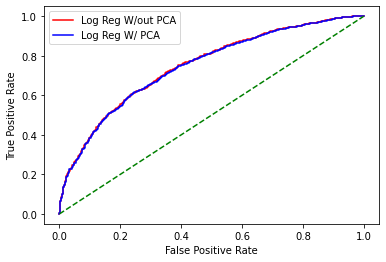

In [100]:
fpr_test, tpr_test, thr_test = roc_curve(y_train, model_lg.predict_proba(X_train)[:,1])
fpr_tr, tpr_tr, thr_tr = roc_curve(y_train, model_lg_pca.predict_proba(X_train)[:,1])

plt.plot(fpr_test, tpr_test, 'red')
plt.plot(fpr_tr, tpr_tr, 'blue')
plt.plot(fpr_tr, fpr_tr, color='green', linestyle='dashed')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Log Reg W/out PCA','Log Reg W/ PCA '])
plt.show()

> The ROC curve shows how similar using and not using PCA is on the model.

#### Chosen Model

In [101]:
model_lg_pca.best_estimator_

Pipeline(steps=[('fp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['err_for_hf', 'err_for_hka',
                                                   'err_for_copd',
                                                   'err_for_cabg',
                                                   'err_for_ami', 'black',
                                                   'asian', 'hispanic',
                                                   'per_cap_inc',
                                                   'unemployment']),
                                                 ('create_dummies',
    

**Best model hyperparameters**

- Regularization strength: 0.005

- PCA components: 18

## Discussion

The best model is logistic regression with PCA, based on the higher AUC and comparable accuracy, recall, precision and runtime. An s-shaped curve seems to represent the data best. The similarity in model performance across the board likely reflects the issues with the data rather than a reflection of the model performance. 


### Next Steps

There are some options to explore to improve model performance.

I. Collecting more data:
- Removing medicaid expansion variable and instead including more states
- Including more features such as patient health characteristics 

II. Using more methods that work better for smaller datasets:
- Using leave one out cross-validation
- Utilizing ensemble methods

III. Modifying analysis:
- employing panel data
- feature engineering to aggregate readmission rates at the hospital level
- experimetn with different binary outcome cut offs

In conclusion, readmission rates for pneumonia can be predicted with 68% accuracy given other readmission rates and demographic data. Pneumonia ERRs are still valuable to collect until there is better data to improve prediction and possibly remove the necessity for reporting that particular metric.

## References

[1] Centers for Medicaid and Medicare Services (n.d.) Hospital Readmissions Reduction Program (HRRP) Measures https://qualitynet.cms.gov/inpatient/hrrp/measures 

[2] Casalino LP, Gans D, Weber R, et al. US Physician Practices Spend More Than $15.4 Billion Annually To Report Quality Measures. Health Aff (Millwood). 2016;35(3):401-406. doi:10.1377/hlthaff.2015.1258

[3] Gai Y, Pachamanova D. Impact of the Medicare hospital readmissions reduction program on vulnerable populations. BMC Health Serv Res. 2019;19(1):837. Published 2019 Nov 14. doi:10.1186/s12913-019-4645-5

[4] Wadhera RK, Joynt Maddox KE, Wasfy JH, Haneuse S, Shen C, Yeh RW. Association of the Hospital Readmissions Reduction Program With Mortality Among Medicare Beneficiaries Hospitalized for Heart Failure, Acute Myocardial Infarction, and Pneumonia. JAMA. 2018;320(24):2542-2552. doi:10.1001/jama.2018.19232

[5] United States Census Bureau (n.d.) Geographic Products Branch U.S. Census Bureau https://www2.census.gov/geo/pdfs/education/CensusTracts.pdf

[6] Sommers, B. D., Maylone, B., Blendon, R. J., Orav, E. J., & Epstein, A. M. (2017). Three-Year Impacts Of The Affordable Care Act: Improved Medical Care And Health Among Low-Income Adults. Health Affairs, 36(6), 1119–1128. 